In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad  # Corrected line
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import random
import pickle


In [15]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU') ) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Windows-11-10.0.26200-SP0
Tensor Flow Version: 2.20.0
Keras Version: 3.11.1

Python 3.13.6 (tags/v3.13.6:4e66535, Aug  6 2025, 14:36:00) [MSC v.1944 64 bit (AMD64)]
Pandas 2.3.1
Scikit-Learn 1.7.1
GPU is NOT AVAILABLE


### Load the training set and testing set

In [16]:
imputed_train_data = pd.read_csv(r'C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\datasets\imputed_dataset\lr_imputed_train.csv')
imputed_test_data = pd.read_csv(r'C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\datasets\imputed_dataset\lr_imputed_test.csv')

### Preprogress both textual and numerical features

In [17]:
# Define input shapes
text_input_shape = (100,)
num_input_shape = (imputed_train_data.shape[1] - 2,)

# Tokenize textual data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, filters='', char_level=True)
tokenizer.fit_on_texts(''.join(imputed_train_data['url']))
vocab_size = len(tokenizer.word_index) + 1

# Textual data
text_train = pad_sequences(tokenizer.texts_to_sequences(imputed_train_data['url']), maxlen=text_input_shape[0], padding="post")
text_test = pad_sequences(tokenizer.texts_to_sequences(imputed_test_data['url']), maxlen=text_input_shape[0], padding="post")

# Numerical data
num_train = imputed_train_data.iloc[:, 1:(num_input_shape[0] + 1)].values
num_test = imputed_test_data.iloc[:, 1:(num_input_shape[0] + 1)].values

mean_sd_sc = StandardScaler()
num_train_std = mean_sd_sc.fit_transform(num_train)
num_test_std = mean_sd_sc.transform(num_test)

# Response
y_train = imputed_train_data.iloc[:, (num_input_shape[0] + 1)].values
y_test = imputed_test_data.iloc[:, (num_input_shape[0] + 1)].values.squeeze()

### Save the std scaler and tokenizer

In [18]:
pickle.dump(mean_sd_sc, open(r'C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\models\preprocessing\std_sc.pkl', 'wb'))
pickle.dump(tokenizer, open(r'C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\models\preprocessing\tokenizer.pkl', 'wb'))

### Define the CNN model that accept both textual and numerical features for classification

In [19]:
def phising_CNNModel(vocab_size, embedding_size=128, conv_num=1, conv_filters=32, conv_kernel_size=5, conv_activation='relu',
                    fc_num=3, fc_units=64, fc_activation='relu', fc_dropout=0.2, learning_rate=0.001, optimizer="Adam"):
    
    # Define the input tensors
    text_input = Input(shape=text_input_shape, name='text_input')
    num_input = Input(shape=num_input_shape, name='num_input')
        
    # Apply the embedding layer to the textual input
    text_embedding = Embedding(vocab_size, embedding_size, input_length=text_input_shape[0])(text_input)

    # Apply the convolutional layers to the textual input
    for num in range(conv_num):
        if num == 0:
            text_conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation=conv_activation, padding='valid')(text_embedding)
        else:
            text_conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation=conv_activation, padding='valid')(text_conv)
    
    # Apply the global max pooling layer before fully-connected layers
    text_pool = GlobalMaxPooling1D()(text_conv)
    
    # Concatenate the textual and numeric features
    concat = Concatenate()([text_pool, num_input])

    # Apply the fully connected layers to the concatenated features
    for num in range(fc_num):
        if num == 0:
            fc = Dense(units=fc_units, activation=fc_activation)(concat)
        else:
            fc = Dense(units=fc_units, activation=fc_activation)(fc)
        fc = Dropout(fc_dropout)(fc)

    # Apply the output layer to the fully connected output
    output = Dense(units=1, activation='sigmoid')(fc)

    # Define the model
    model = Model(inputs=[text_input, num_input], outputs=output)
    
    # Define optimizer
    if optimizer == 'Adam':
        optim = Adam(learning_rate)
    elif optimizer == 'SGD':
        optim = SGD(learning_rate)
    elif optimizer == 'RMSprop':
        optim = RMSprop(learning_rate)
    elif optimizer == 'Adagrad':
        optim = Adagrad(learning_rate)

    # Compile the model
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

    return model

### Define the function for K-fold Cross validation

In [20]:
def cross_validate(cv, model, param, text_train, num_train, y_train, scaler=None, verbose=0):
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(num_train, y_train)):
        print('Fold', fold + 1)

        # Define the training set and validation set 
        X_text_train, X_num_train, Y_train = text_train[train_idx] ,num_train[train_idx], y_train[train_idx]
        X_text_val, X_num_val, Y_val = text_train[val_idx], num_train[val_idx], y_train[val_idx]
        
        # Tokenize the url data
        tokenizer = Tokenizer(num_words=num_words, filters='', char_level=True)
        tokenizer.fit_on_texts(''.join(X_text_train))
        vocab_size = len(tokenizer.word_index) + 1

        # Textual data
        X_text_train = pad_sequences(tokenizer.texts_to_sequences(X_text_train), maxlen=text_input_shape[0], padding="post")
        X_text_val = pad_sequences(tokenizer.texts_to_sequences(X_text_val), maxlen=text_input_shape[0], padding="post")
            
        # Normalize the num_train
        if scaler != None:
            X_num_train = scaler.fit_transform(X_num_train)
            X_num_val = scaler.transform(X_num_val)
            
        # Define the model
        train_model = model(vocab_size=vocab_size, embedding_size=param[0], conv_num=param[1], conv_filters=param[2], conv_kernel_size=param[3], 
                            conv_activation=param[4], fc_num=param[5], fc_units=param[6], fc_activation=param[7], 
                            fc_dropout=param[8], learning_rate=param[9], optimizer=param[10])
            
        # Build and train the model
        early_stopping = EarlyStopping(monitor="val_loss", patience=3)
        train_model.fit([X_text_train, X_num_train], Y_train, 
                        batch_size=param[11], epochs=30, 
                        validation_split=0.1, 
                        callbacks=[early_stopping], verbose=verbose)

        # Evaluate the model on the train and the val set
        train_metrix = train_model.evaluate([X_text_train, X_num_train], Y_train, verbose=verbose)
        val_metrix = train_model.evaluate([X_text_val, X_num_val], Y_val, verbose=verbose)
            
        # Accuracy scores
        train_score = train_metrix[1]
        val_score = val_metrix[1]
        train_scores.append(train_score)
        val_scores.append(val_score)
            
        # Loss
        train_loss = train_metrix[0]
        val_loss = val_metrix[0]
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Report the scores
        print(f"Training accuracy = {train_score:.4f} & training loss = {train_loss:.4f}")
        print(f"Validation accuracy = {val_score:.4f} & validation loss = {val_loss:.4f}")

    # Report the 5-folder scores and losses
    print(f'5-folders CV training accuracy = {np.mean(train_scores)} & loss = {np.mean(train_losses)}')
    print(f'5-folders CV validation accuracy = {np.mean(val_scores)} & loss = {np.mean(val_losses)}')
    return np.mean(train_scores), np.mean(train_losses), np.mean(val_scores), np.mean(val_losses)

### Initial model

In [21]:
initial_model = phising_CNNModel(vocab_size=vocab_size, embedding_size=128, conv_num=1, conv_filters=32, conv_kernel_size=5, conv_activation='relu',
                                fc_num=3, fc_units=64, fc_activation='relu', fc_dropout=0.2, learning_rate=0.001, optimizer='Adam')
initial_model.summary()

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │      8,192 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 96, 32)    │     20,512 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 66)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,288 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,377 (161.63 KB)

 Trainable params: 41,377 (161.63 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
keras.utils.plot_model(initial_model, r'C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\initCNN_arch.png', show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [23]:
# Define the cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=4012)

In [24]:
init_parm = [128, 1, 32, 5, 'relu', 3, 64, 'relu', 0.2, 0.001, 'Adam', 32]
initial_score = cross_validate(cv, phising_CNNModel, init_parm, imputed_train_data['url'], num_train, y_train, scaler=mean_sd_sc, verbose=1)

Fold 1
Epoch 1/30


c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8623 - loss: 0.3299 - val_accuracy: 0.9214 - val_loss: 0.1923
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9203 - loss: 0.2057 - val_accuracy: 0.9356 - val_loss: 0.1582
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9359 - loss: 0.1696 - val_accuracy: 0.9391 - val_loss: 0.1510
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9498 - loss: 0.1386 - val_accuracy: 0.9426 - val_loss: 0.1427
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9585 - loss: 0.1151 - val_accuracy: 0.9444 - val_loss: 0.1581
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9654 - loss: 0.0951 - val_accuracy: 0.9462 - val_loss: 0.1378
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9701 - loss: 0.0832 - val_accuracy: 0.9462 - val_loss: 0.1426
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9724 - loss: 0.0754 - val_accuracy: 0.9444 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8592 - loss: 0.3337 - val_accuracy: 0.9135 - val_loss: 0.2079
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9205 - loss: 0.2051 - val_accuracy: 0.9285 - val_loss: 0.1798
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9405 - loss: 0.1583 - val_accuracy: 0.9250 - val_loss: 0.1961
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9523 - loss: 0.1277 - val_accuracy: 0.9356 - val_loss: 0.1628
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9577 - loss: 0.1135 - val_accuracy: 0.9373 - val_loss: 0.1826
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9670 - loss: 0.0900 - val_accuracy: 0.9479 - val_loss: 0.1516
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9698 - loss: 0.0813 - val_accuracy: 0.9409 - val_loss: 0.1708
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9774 - loss: 0.0641 - val_accuracy: 0.9417 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8616 - loss: 0.3294 - val_accuracy: 0.9179 - val_loss: 0.2092
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9207 - loss: 0.2053 - val_accuracy: 0.9259 - val_loss: 0.1711
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9366 - loss: 0.1725 - val_accuracy: 0.9426 - val_loss: 0.1483
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9479 - loss: 0.1408 - val_accuracy: 0.9523 - val_loss: 0.1376
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9538 - loss: 0.1255 - val_accuracy: 0.9497 - val_loss: 0.1411
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9613 - loss: 0.1088 - val_accuracy: 0.9462 - val_loss: 0.1533
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9655 - loss: 0.0934 - val_accuracy: 0.9532 - val_loss: 0.1785
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9744 - loss: 0.0761
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8592 - loss: 0.3328 - val_accuracy: 0.9135 - val_loss: 0.2214
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9224 - loss: 0.2032 - val_accuracy: 0.9241 - val_loss: 0.1863
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9381 - loss: 0.1643 - val_accuracy: 0.9320 - val_loss: 0.1689
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9481 - loss: 0.1372 - val_accuracy: 0.9320 - val_loss: 0.1674
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9582 - loss: 0.1141 - val_accuracy: 0.9426 - val_loss: 0.1597
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9591 - loss: 0.1070 - val_accuracy: 0.9435 - val_loss: 0.1408
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9685 - loss: 0.0859 - val_accuracy: 0.9356 - val_loss: 0.1719
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9694 - loss: 0.0820 - val_accuracy: 0.9444 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8556 - loss: 0.3453 - val_accuracy: 0.9082 - val_loss: 0.2209
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9203 - loss: 0.2071 - val_accuracy: 0.9294 - val_loss: 0.1835
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9367 - loss: 0.1686 - val_accuracy: 0.9382 - val_loss: 0.1698
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9473 - loss: 0.1403 - val_accuracy: 0.9479 - val_loss: 0.1455
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9551 - loss: 0.1199 - val_accuracy: 0.9470 - val_loss: 0.1531
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9653 - loss: 0.0928 - val_accuracy: 0.9515 - val_loss: 0.1459
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9686 - loss: 0.0853 - val_accuracy: 0.9532 - val_loss: 0.1321
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9732 - loss: 0.0755 - val_accuracy: 0.9585 - val_

In [25]:
best_socre = initial_score[2]
best_socre

np.float64(0.94491525888443)

### Define the function for random search

In [26]:
def random_search(cv, model, param_dist, text_train, num_train, y_train, int_score=0, scaler=None, seed=None, i_ter=10, verbose=0):
    train_cv_scores = []
    train_cv_losses = []
    val_cv_scores = []
    val_cv_losses = []
    
    best_score = int_score
    best_param = []
    
    for i in range(i_ter):
        print(f'Search {i +1}')
        # Select parameters
        if seed != None:
            random.seed(seed + i)
        param = [random.choice(param_dist[item]) for item in param_dist]
        print(f'Combination = {param}')
        
        # CV
        cv_score = cross_validate(cv, phising_CNNModel, param, text_train, num_train, y_train, scaler=scaler, verbose=verbose)
        train_cv_scores.append(cv_score[0])
        train_cv_losses.append(cv_score[1])
        val_cv_scores.append(cv_score[2])
        val_cv_losses.append(cv_score[3])
        
        if val_cv_scores[i] > best_score:
            best_score = val_cv_scores[i]
            best_param = param

    return best_param, best_score, train_cv_scores, train_cv_losses, val_cv_scores, val_cv_losses

In [27]:
# Define the search space for your hyperparameters
param_dist = {
    'embedding_size': [64, 128, 256],
    'conv_num': [1, 2, 3],
    'conv_filters': [32, 64, 128],
    'conv_kernel_size': [3, 5],
    'conv_activation': ['relu', 'sigmoid'],
    'fc_num': [2, 3, 4],
    'fc_units': [64, 128, 256],
    'fc_activation': ['relu', 'sigmoid'],
    'fc_dropout': [0.0, 0.2, 0.4],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'batch_size': [32]
}

In [28]:
CNN_search = random_search(cv, phising_CNNModel, param_dist, imputed_train_data['url'], num_train, y_train, 
                           int_score=best_socre, scaler=mean_sd_sc, seed=4012, i_ter=10, verbose=1)

Search 1
Combination = [64, 3, 128, 5, 'relu', 2, 64, 'relu', 0.0, 0.001, 'Adam', 32]
Fold 1
Epoch 1/30


c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8761 - loss: 0.2959 - val_accuracy: 0.9162 - val_loss: 0.1936
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9233 - loss: 0.1913 - val_accuracy: 0.9276 - val_loss: 0.1626
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9367 - loss: 0.1577 - val_accuracy: 0.9365 - val_loss: 0.1485
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9500 - loss: 0.1287 - val_accuracy: 0.9506 - val_loss: 0.1114
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9610 - loss: 0.1070 - val_accuracy: 0.9506 - val_loss: 0.1161
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9680 - loss: 0.0880 - val_accuracy: 0.9620 - val_loss: 0.0981
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9784 - loss: 0.0621 - val_accuracy: 0.9515 - val_loss: 0.1328
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9843 - loss: 0.0457 - val_accuracy: 0.959

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8736 - loss: 0.2984 - val_accuracy: 0.8976 - val_loss: 0.2282
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9282 - loss: 0.1813 - val_accuracy: 0.9267 - val_loss: 0.1718
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9481 - loss: 0.1371 - val_accuracy: 0.9373 - val_loss: 0.1584
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9609 - loss: 0.1062 - val_accuracy: 0.9488 - val_loss: 0.1430
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9736 - loss: 0.0768 - val_accuracy: 0.9365 - val_loss: 0.1767
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9806 - loss: 0.0538 - val_accuracy: 0.9444 - val_loss: 0.1721
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9857 - loss: 0.0411 - val_accuracy: 0.9532 - val_loss: 0.1677
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9860 - loss: 0.0457
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8813 - loss: 0.2801 - val_accuracy: 0.9232 - val_loss: 0.1853
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9285 - loss: 0.1790 - val_accuracy: 0.9391 - val_loss: 0.1627
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9456 - loss: 0.1417 - val_accuracy: 0.9541 - val_loss: 0.1314
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9585 - loss: 0.1113 - val_accuracy: 0.9541 - val_loss: 0.1380
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9696 - loss: 0.0864 - val_accuracy: 0.9515 - val_loss: 0.1295
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9737 - loss: 0.0703 - val_accuracy: 0.9559 - val_loss: 0.1315
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9812 - loss: 0.0536 - val_accuracy: 0.9523 - val_loss: 0.1453
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9905 - loss: 0.0294 - val_accuracy: 0.958

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8820 - loss: 0.2795 - val_accuracy: 0.9153 - val_loss: 0.2096
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9309 - loss: 0.1729 - val_accuracy: 0.9303 - val_loss: 0.1650
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9496 - loss: 0.1317 - val_accuracy: 0.9435 - val_loss: 0.1453
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9631 - loss: 0.0991 - val_accuracy: 0.9347 - val_loss: 0.1634
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9726 - loss: 0.0758 - val_accuracy: 0.9453 - val_loss: 0.1462
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9793 - loss: 0.0564 - val_accuracy: 0.9532 - val_loss: 0.1428
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9871 - loss: 0.0363 - val_accuracy: 0.9541 - val_loss: 0.1508
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9903 - loss: 0.0294 - val_accuracy: 0.957

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8781 - loss: 0.2907 - val_accuracy: 0.9073 - val_loss: 0.2109
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9278 - loss: 0.1865 - val_accuracy: 0.9382 - val_loss: 0.1744
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9408 - loss: 0.1472 - val_accuracy: 0.9488 - val_loss: 0.1326
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9529 - loss: 0.1201 - val_accuracy: 0.9444 - val_loss: 0.1294
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9645 - loss: 0.0979 - val_accuracy: 0.9532 - val_loss: 0.1316
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9745 - loss: 0.0747 - val_accuracy: 0.9470 - val_loss: 0.1203
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9796 - loss: 0.0589 - val_accuracy: 0.9497 - val_loss: 0.1461
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9866 - loss: 0.0408 - val_accuracy: 0.944

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7683 - loss: 0.4661 - val_accuracy: 0.9011 - val_loss: 0.2483
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8940 - loss: 0.2768 - val_accuracy: 0.9135 - val_loss: 0.2205
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9080 - loss: 0.2428 - val_accuracy: 0.9153 - val_loss: 0.2049
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9131 - loss: 0.2241 - val_accuracy: 0.9179 - val_loss: 0.1926
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9253 - loss: 0.1994 - val_accuracy: 0.9232 - val_loss: 0.1818
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9325 - loss: 0.1809 - val_accuracy: 0.9250 - val_loss: 0.1741
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9387 - loss: 0.1683 - val_accuracy: 0.9356 - val_loss: 0.1628
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9462 - loss: 0.1495 - val_accuracy: 0.9382 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7483 - loss: 0.4766 - val_accuracy: 0.8932 - val_loss: 0.2638
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8956 - loss: 0.2668 - val_accuracy: 0.8994 - val_loss: 0.2280
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9107 - loss: 0.2338 - val_accuracy: 0.9082 - val_loss: 0.2305
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9225 - loss: 0.2087 - val_accuracy: 0.9073 - val_loss: 0.2052
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9315 - loss: 0.1923 - val_accuracy: 0.9162 - val_loss: 0.1975
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9382 - loss: 0.1692 - val_accuracy: 0.9153 - val_loss: 0.2006
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9467 - loss: 0.1493 - val_accuracy: 0.9170 - val_loss: 0.2026
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9516 - loss: 0.1355 - val_accuracy: 0.9259 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7686 - loss: 0.4592 - val_accuracy: 0.8950 - val_loss: 0.2653
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8913 - loss: 0.2748 - val_accuracy: 0.9056 - val_loss: 0.2192
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9024 - loss: 0.2525 - val_accuracy: 0.9056 - val_loss: 0.2140
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9103 - loss: 0.2340 - val_accuracy: 0.9188 - val_loss: 0.1927
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9177 - loss: 0.2170 - val_accuracy: 0.9232 - val_loss: 0.1871
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9290 - loss: 0.1942 - val_accuracy: 0.9232 - val_loss: 0.1842
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9342 - loss: 0.1825 - val_accuracy: 0.9223 - val_loss: 0.1829
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9419 - loss: 0.1627 - val_accuracy: 0.9276 - val

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7640 - loss: 0.4727 - val_accuracy: 0.8844 - val_loss: 0.2724
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8982 - loss: 0.2662 - val_accuracy: 0.8950 - val_loss: 0.2385
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9095 - loss: 0.2409 - val_accuracy: 0.9011 - val_loss: 0.2251
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9162 - loss: 0.2198 - val_accuracy: 0.9073 - val_loss: 0.2156
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9274 - loss: 0.1988 - val_accuracy: 0.9144 - val_loss: 0.1993
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9357 - loss: 0.1831 - val_accuracy: 0.9170 - val_loss: 0.1941
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9389 - loss: 0.1702 - val_accuracy: 0.9223 - val_loss: 0.1846
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9444 - loss: 0.1509 - val_accuracy: 0.9241 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7559 - loss: 0.4774 - val_accuracy: 0.8941 - val_loss: 0.2663
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8928 - loss: 0.2741 - val_accuracy: 0.8950 - val_loss: 0.2358
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9014 - loss: 0.2524 - val_accuracy: 0.9064 - val_loss: 0.2151
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9091 - loss: 0.2320 - val_accuracy: 0.9047 - val_loss: 0.2295
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9197 - loss: 0.2101 - val_accuracy: 0.9188 - val_loss: 0.1982
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9296 - loss: 0.1910 - val_accuracy: 0.9312 - val_loss: 0.1756
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9383 - loss: 0.1711 - val_accuracy: 0.9338 - val_loss: 0.1742
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9453 - loss: 0.1558 - val_accuracy: 0.9312 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8884 - loss: 0.2672 - val_accuracy: 0.9109 - val_loss: 0.2073
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9367 - loss: 0.1628 - val_accuracy: 0.9497 - val_loss: 0.1407
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9564 - loss: 0.1195 - val_accuracy: 0.9559 - val_loss: 0.1123
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9666 - loss: 0.0924 - val_accuracy: 0.9603 - val_loss: 0.1112
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9759 - loss: 0.0722 - val_accuracy: 0.9550 - val_loss: 0.1207
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9790 - loss: 0.0593 - val_accuracy: 0.9638 - val_loss: 0.1093
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9839 - loss: 0.0469 - val_accuracy: 0.9576 - val_loss: 0.1238
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9880 - loss: 0.0349 - val_accuracy: 0.954

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8874 - loss: 0.2680 - val_accuracy: 0.9153 - val_loss: 0.1800
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9374 - loss: 0.1608 - val_accuracy: 0.9259 - val_loss: 0.1617
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9533 - loss: 0.1205 - val_accuracy: 0.9479 - val_loss: 0.1380
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9645 - loss: 0.0925 - val_accuracy: 0.9550 - val_loss: 0.1330
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9778 - loss: 0.0636 - val_accuracy: 0.9488 - val_loss: 0.1429
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9806 - loss: 0.0535 - val_accuracy: 0.9444 - val_loss: 0.1703
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9838 - loss: 0.0448 - val_accuracy: 0.9409 - val_loss: 0.1745
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9831 - loss: 0.0479
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8927 - loss: 0.2639 - val_accuracy: 0.9206 - val_loss: 0.1821
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9382 - loss: 0.1581 - val_accuracy: 0.9382 - val_loss: 0.1542
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9546 - loss: 0.1197 - val_accuracy: 0.9506 - val_loss: 0.1210
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9665 - loss: 0.0924 - val_accuracy: 0.9532 - val_loss: 0.1299
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9770 - loss: 0.0678 - val_accuracy: 0.9594 - val_loss: 0.1103
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9801 - loss: 0.0567 - val_accuracy: 0.9603 - val_loss: 0.1293
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9858 - loss: 0.0439 - val_accuracy: 0.9435 - val_loss: 0.1693
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9841 - loss: 0.0420 - val_accuracy: 0.963

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8921 - loss: 0.2546 - val_accuracy: 0.9135 - val_loss: 0.2025
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9369 - loss: 0.1568 - val_accuracy: 0.9338 - val_loss: 0.1519
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9533 - loss: 0.1223 - val_accuracy: 0.9373 - val_loss: 0.1337
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9665 - loss: 0.0878 - val_accuracy: 0.9497 - val_loss: 0.1338
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9768 - loss: 0.0666 - val_accuracy: 0.9470 - val_loss: 0.1303
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9833 - loss: 0.0478 - val_accuracy: 0.9559 - val_loss: 0.1275
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9873 - loss: 0.0371 - val_accuracy: 0.9541 - val_loss: 0.1661
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9896 - loss: 0.0332 - val_accuracy: 0.955

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8876 - loss: 0.2668 - val_accuracy: 0.9259 - val_loss: 0.1800
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9363 - loss: 0.1629 - val_accuracy: 0.9470 - val_loss: 0.1418
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9557 - loss: 0.1204 - val_accuracy: 0.9312 - val_loss: 0.1763
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9676 - loss: 0.0887 - val_accuracy: 0.9488 - val_loss: 0.1312
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9765 - loss: 0.0662 - val_accuracy: 0.9479 - val_loss: 0.1463
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9838 - loss: 0.0471 - val_accuracy: 0.9559 - val_loss: 0.1321
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9850 - loss: 0.0415 - val_accuracy: 0.9515 - val_loss: 0.1428
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9854 - loss: 0.0447
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8937 - loss: 0.2560 - val_accuracy: 0.9338 - val_loss: 0.1738
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9382 - loss: 0.1592 - val_accuracy: 0.9267 - val_loss: 0.1814
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9557 - loss: 0.1161 - val_accuracy: 0.9497 - val_loss: 0.1304
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9646 - loss: 0.0943 - val_accuracy: 0.9391 - val_loss: 0.1623
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9724 - loss: 0.0755 - val_accuracy: 0.9594 - val_loss: 0.1063
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9829 - loss: 0.0541 - val_accuracy: 0.9506 - val_loss: 0.1274
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9829 - loss: 0.0465 - val_accuracy: 0.9568 - val_loss: 0.1274
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9872 - loss: 0.0387 - val_accuracy: 0.953

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8999 - loss: 0.2514 - val_accuracy: 0.9232 - val_loss: 0.1801
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9431 - loss: 0.1482 - val_accuracy: 0.9267 - val_loss: 0.1610
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9599 - loss: 0.1084 - val_accuracy: 0.9470 - val_loss: 0.1392
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9673 - loss: 0.0889 - val_accuracy: 0.9559 - val_loss: 0.1310
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9746 - loss: 0.0678 - val_accuracy: 0.9506 - val_loss: 0.1508
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9808 - loss: 0.0567 - val_accuracy: 0.9559 - val_loss: 0.1384
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9849 - loss: 0.0430 - val_accuracy: 0.9550 - val_loss: 0.1549
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9831 - loss: 0.0508
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8890 - loss: 0.2656 - val_accuracy: 0.9223 - val_loss: 0.1943
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9392 - loss: 0.1604 - val_accuracy: 0.9409 - val_loss: 0.1517
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9548 - loss: 0.1219 - val_accuracy: 0.9532 - val_loss: 0.1336
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9635 - loss: 0.0965 - val_accuracy: 0.9576 - val_loss: 0.1279
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9735 - loss: 0.0770 - val_accuracy: 0.9523 - val_loss: 0.1247
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9781 - loss: 0.0620 - val_accuracy: 0.9568 - val_loss: 0.1330
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9816 - loss: 0.0528 - val_accuracy: 0.9488 - val_loss: 0.1477
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9841 - loss: 0.0436 - val_accuracy: 0.9576 - val

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8936 - loss: 0.2572 - val_accuracy: 0.9064 - val_loss: 0.2074
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9410 - loss: 0.1555 - val_accuracy: 0.9382 - val_loss: 0.1533
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9565 - loss: 0.1182 - val_accuracy: 0.9470 - val_loss: 0.1487
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9676 - loss: 0.0874 - val_accuracy: 0.9303 - val_loss: 0.2049
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9718 - loss: 0.0741 - val_accuracy: 0.9594 - val_loss: 0.1277
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9798 - loss: 0.0575 - val_accuracy: 0.9559 - val_loss: 0.1444
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9816 - loss: 0.0462 - val_accuracy: 0.9532 - val_loss: 0.1458
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9870 - loss: 0.0384 - val_accuracy: 0.959

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8925 - loss: 0.2597 - val_accuracy: 0.9276 - val_loss: 0.1847
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9359 - loss: 0.1630 - val_accuracy: 0.9409 - val_loss: 0.1544
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9558 - loss: 0.1161 - val_accuracy: 0.9568 - val_loss: 0.1282
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9656 - loss: 0.0975 - val_accuracy: 0.9585 - val_loss: 0.1231
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9745 - loss: 0.0725 - val_accuracy: 0.9656 - val_loss: 0.1141
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9789 - loss: 0.0586 - val_accuracy: 0.9585 - val_loss: 0.1238
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9807 - loss: 0.0488 - val_accuracy: 0.9515 - val_loss: 0.1411
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9863 - loss: 0.0389 - val_accuracy: 0.944

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7667 - loss: 0.4942 - val_accuracy: 0.8888 - val_loss: 0.2853
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8774 - loss: 0.3305 - val_accuracy: 0.8994 - val_loss: 0.2471
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8896 - loss: 0.2868 - val_accuracy: 0.9029 - val_loss: 0.2237
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8984 - loss: 0.2669 - val_accuracy: 0.9214 - val_loss: 0.2004
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9089 - loss: 0.2388 - val_accuracy: 0.9285 - val_loss: 0.1840
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9154 - loss: 0.2262 - val_accuracy: 0.9347 - val_loss: 0.1690
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9179 - loss: 0.2141 - val_accuracy: 0.9303 - val_loss: 0.1796
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9186 - loss: 0.2086 - val_accuracy: 0.9382 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7629 - loss: 0.4972 - val_accuracy: 0.8756 - val_loss: 0.2839
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8763 - loss: 0.3265 - val_accuracy: 0.8870 - val_loss: 0.2624
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8907 - loss: 0.2938 - val_accuracy: 0.8959 - val_loss: 0.2465
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8950 - loss: 0.2754 - val_accuracy: 0.9020 - val_loss: 0.2244
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9028 - loss: 0.2560 - val_accuracy: 0.9117 - val_loss: 0.2120
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9036 - loss: 0.2436 - val_accuracy: 0.9126 - val_loss: 0.2081
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9148 - loss: 0.2246 - val_accuracy: 0.9206 - val_loss: 0.1914
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9196 - loss: 0.2143 - val_accuracy: 0.9241 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7746 - loss: 0.4862 - val_accuracy: 0.8914 - val_loss: 0.2609
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8802 - loss: 0.3328 - val_accuracy: 0.9011 - val_loss: 0.2384
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8879 - loss: 0.2928 - val_accuracy: 0.9179 - val_loss: 0.2148
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8982 - loss: 0.2663 - val_accuracy: 0.9153 - val_loss: 0.2019
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9080 - loss: 0.2419 - val_accuracy: 0.9276 - val_loss: 0.1900
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9110 - loss: 0.2351 - val_accuracy: 0.9285 - val_loss: 0.1795
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9158 - loss: 0.2234 - val_accuracy: 0.9303 - val_loss: 0.1748
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9215 - loss: 0.2061 - val_accuracy: 0.9285 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7860 - loss: 0.4704 - val_accuracy: 0.8853 - val_loss: 0.2861
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8782 - loss: 0.3211 - val_accuracy: 0.8906 - val_loss: 0.2662
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8888 - loss: 0.2806 - val_accuracy: 0.8976 - val_loss: 0.2441
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8994 - loss: 0.2525 - val_accuracy: 0.9011 - val_loss: 0.2275
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9122 - loss: 0.2365 - val_accuracy: 0.9144 - val_loss: 0.2151
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9197 - loss: 0.2122 - val_accuracy: 0.9153 - val_loss: 0.2067
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9184 - loss: 0.2117 - val_accuracy: 0.9179 - val_loss: 0.2006
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9227 - loss: 0.2018 - val_accuracy: 0.9214 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7742 - loss: 0.4746 - val_accuracy: 0.8897 - val_loss: 0.2725
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8735 - loss: 0.3276 - val_accuracy: 0.8941 - val_loss: 0.2554
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8893 - loss: 0.2805 - val_accuracy: 0.9047 - val_loss: 0.2355
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8981 - loss: 0.2597 - val_accuracy: 0.9153 - val_loss: 0.2140
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9077 - loss: 0.2394 - val_accuracy: 0.9170 - val_loss: 0.2023
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9121 - loss: 0.2286 - val_accuracy: 0.9223 - val_loss: 0.1948
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9182 - loss: 0.2118 - val_accuracy: 0.9259 - val_loss: 0.1813
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9221 - loss: 0.2074 - val_accuracy: 0.9329 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8859 - loss: 0.2772 - val_accuracy: 0.9135 - val_loss: 0.1999
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9364 - loss: 0.1661 - val_accuracy: 0.9576 - val_loss: 0.1251
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9559 - loss: 0.1238 - val_accuracy: 0.9497 - val_loss: 0.1308
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9663 - loss: 0.0935 - val_accuracy: 0.9612 - val_loss: 0.1120
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9758 - loss: 0.0666 - val_accuracy: 0.9426 - val_loss: 0.1637
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9820 - loss: 0.0500 - val_accuracy: 0.9559 - val_loss: 0.1346
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9889 - loss: 0.0303 - val_accuracy: 0.9523 - val_loss: 0.1496
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9888 - loss: 0.0334
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8828 - loss: 0.2763 - val_accuracy: 0.9241 - val_loss: 0.1832
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9404 - loss: 0.1599 - val_accuracy: 0.9329 - val_loss: 0.1503
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9575 - loss: 0.1185 - val_accuracy: 0.9515 - val_loss: 0.1254
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9708 - loss: 0.0844 - val_accuracy: 0.9497 - val_loss: 0.1439
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9809 - loss: 0.0575 - val_accuracy: 0.9488 - val_loss: 0.1664
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9818 - loss: 0.0491 - val_accuracy: 0.9541 - val_loss: 0.1470
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9899 - loss: 0.0333
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9509 - loss: 0.1686
Training accuracy = 0.9899 & training loss = 0.0333
Validation accuracy = 0.9509 & valida

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8859 - loss: 0.2758 - val_accuracy: 0.9188 - val_loss: 0.1965
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9337 - loss: 0.1693 - val_accuracy: 0.9426 - val_loss: 0.1560
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9544 - loss: 0.1266 - val_accuracy: 0.9497 - val_loss: 0.1222
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9660 - loss: 0.0932 - val_accuracy: 0.9435 - val_loss: 0.1545
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9787 - loss: 0.0636 - val_accuracy: 0.9409 - val_loss: 0.1890
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9846 - loss: 0.0458 - val_accuracy: 0.9559 - val_loss: 0.1349
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9885 - loss: 0.0337
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9566 - loss: 0.1539
Training accuracy = 0.9885 & training loss = 0.0337
Validation accuracy = 0.9566 & valida

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8867 - loss: 0.2828 - val_accuracy: 0.9188 - val_loss: 0.1971
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9353 - loss: 0.1678 - val_accuracy: 0.9303 - val_loss: 0.1630
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9548 - loss: 0.1223 - val_accuracy: 0.9382 - val_loss: 0.1481
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9695 - loss: 0.0864 - val_accuracy: 0.9479 - val_loss: 0.1493
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9779 - loss: 0.0618 - val_accuracy: 0.9426 - val_loss: 0.1604
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9820 - loss: 0.0496 - val_accuracy: 0.9462 - val_loss: 0.1762
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9861 - loss: 0.0430
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9509 - loss: 0.1702
Training accuracy = 0.9861 & training loss = 0.0430
Validation accuracy = 0.9509 & valida

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8851 - loss: 0.2783 - val_accuracy: 0.9197 - val_loss: 0.2006
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9351 - loss: 0.1652 - val_accuracy: 0.9444 - val_loss: 0.1514
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9548 - loss: 0.1261 - val_accuracy: 0.9532 - val_loss: 0.1290
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9680 - loss: 0.0879 - val_accuracy: 0.9523 - val_loss: 0.1318
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9774 - loss: 0.0635 - val_accuracy: 0.9568 - val_loss: 0.1270
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9832 - loss: 0.0466 - val_accuracy: 0.9497 - val_loss: 0.1350
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9872 - loss: 0.0359 - val_accuracy: 0.9435 - val_loss: 0.2283
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9884 - loss: 0.0312 - val_accuracy: 0.961

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8748 - loss: 0.2907 - val_accuracy: 0.9135 - val_loss: 0.2137
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9203 - loss: 0.1953 - val_accuracy: 0.9373 - val_loss: 0.1582
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9326 - loss: 0.1682 - val_accuracy: 0.9409 - val_loss: 0.1484
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9462 - loss: 0.1381 - val_accuracy: 0.9541 - val_loss: 0.1230
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9569 - loss: 0.1161 - val_accuracy: 0.9479 - val_loss: 0.1270
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9659 - loss: 0.0905 - val_accuracy: 0.9647 - val_loss: 0.1063
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9778 - loss: 0.0679 - val_accuracy: 0.9523 - val_loss: 0.1362
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9811 - loss: 0.0534 - val_accuracy: 0.910

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8849 - loss: 0.2749 - val_accuracy: 0.9109 - val_loss: 0.2092
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9239 - loss: 0.1929 - val_accuracy: 0.9223 - val_loss: 0.1740
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9358 - loss: 0.1576 - val_accuracy: 0.9338 - val_loss: 0.1545
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9491 - loss: 0.1358 - val_accuracy: 0.9382 - val_loss: 0.1499
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9612 - loss: 0.1060 - val_accuracy: 0.9435 - val_loss: 0.1405
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9670 - loss: 0.0864 - val_accuracy: 0.9453 - val_loss: 0.1516
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9770 - loss: 0.0676 - val_accuracy: 0.9417 - val_loss: 0.1626
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9817 - loss: 0.0559 - val_accuracy: 0.958

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8813 - loss: 0.2822 - val_accuracy: 0.9162 - val_loss: 0.2083
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9184 - loss: 0.1973 - val_accuracy: 0.9179 - val_loss: 0.1954
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9344 - loss: 0.1691 - val_accuracy: 0.9373 - val_loss: 0.1512
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9429 - loss: 0.1483 - val_accuracy: 0.9488 - val_loss: 0.1382
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9506 - loss: 0.1287 - val_accuracy: 0.9497 - val_loss: 0.1347
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9604 - loss: 0.1073 - val_accuracy: 0.9426 - val_loss: 0.1692
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9669 - loss: 0.0925 - val_accuracy: 0.9550 - val_loss: 0.1237
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9735 - loss: 0.0695 - val_accuracy: 0.9585

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8795 - loss: 0.2882 - val_accuracy: 0.8950 - val_loss: 0.2371
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9184 - loss: 0.2029 - val_accuracy: 0.8861 - val_loss: 0.2657
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9346 - loss: 0.1636 - val_accuracy: 0.9276 - val_loss: 0.1789
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9419 - loss: 0.1430 - val_accuracy: 0.9303 - val_loss: 0.1663
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9527 - loss: 0.1210 - val_accuracy: 0.9285 - val_loss: 0.1793
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9638 - loss: 0.0964 - val_accuracy: 0.9409 - val_loss: 0.1458
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9753 - loss: 0.0697 - val_accuracy: 0.9312 - val_loss: 0.1709
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9811 - loss: 0.0538 - val_accuracy: 0.9400 - val

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8810 - loss: 0.2813 - val_accuracy: 0.9091 - val_loss: 0.2132
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9125 - loss: 0.2075 - val_accuracy: 0.9267 - val_loss: 0.1843
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9312 - loss: 0.1730 - val_accuracy: 0.9373 - val_loss: 0.1653
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9423 - loss: 0.1452 - val_accuracy: 0.9232 - val_loss: 0.1838
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9544 - loss: 0.1221 - val_accuracy: 0.9550 - val_loss: 0.1252
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9628 - loss: 0.0966 - val_accuracy: 0.9188 - val_loss: 0.2008
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9711 - loss: 0.0791 - val_accuracy: 0.9585 - val_loss: 0.1171
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9784 - loss: 0.0590 - val_accuracy: 0.9620 - val

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8045 - loss: 0.4088 - val_accuracy: 0.8844 - val_loss: 0.2669
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9086 - loss: 0.2386 - val_accuracy: 0.9170 - val_loss: 0.1975
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9240 - loss: 0.2030 - val_accuracy: 0.9179 - val_loss: 0.1803
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9378 - loss: 0.1677 - val_accuracy: 0.9162 - val_loss: 0.2176
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9473 - loss: 0.1425 - val_accuracy: 0.9320 - val_loss: 0.1758
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9572 - loss: 0.1194 - val_accuracy: 0.9329 - val_loss: 0.1655
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9647 - loss: 0.1008 - val_accuracy: 0.9356 - val_loss: 0.1834
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9708 - loss: 0.0806 - val_accuracy: 0.927

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8093 - loss: 0.4057 - val_accuracy: 0.8879 - val_loss: 0.2569
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9011 - loss: 0.2424 - val_accuracy: 0.9135 - val_loss: 0.2143
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9204 - loss: 0.2025 - val_accuracy: 0.9126 - val_loss: 0.2071
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9352 - loss: 0.1686 - val_accuracy: 0.9162 - val_loss: 0.1919
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9486 - loss: 0.1415 - val_accuracy: 0.9276 - val_loss: 0.1842
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9563 - loss: 0.1179 - val_accuracy: 0.9303 - val_loss: 0.1689
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9653 - loss: 0.0978 - val_accuracy: 0.9312 - val_loss: 0.1929
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9757 - loss: 0.0723 - val_accuracy: 0.927

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8035 - loss: 0.4151 - val_accuracy: 0.9135 - val_loss: 0.2330
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9019 - loss: 0.2453 - val_accuracy: 0.9179 - val_loss: 0.1904
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9186 - loss: 0.2052 - val_accuracy: 0.9223 - val_loss: 0.1849
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9359 - loss: 0.1714 - val_accuracy: 0.9241 - val_loss: 0.1782
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9456 - loss: 0.1542 - val_accuracy: 0.9320 - val_loss: 0.1771
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9524 - loss: 0.1333 - val_accuracy: 0.9391 - val_loss: 0.1554
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9611 - loss: 0.1139 - val_accuracy: 0.9373 - val_loss: 0.1736
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9671 - loss: 0.0961 - val_accuracy: 0.942

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8095 - loss: 0.4168 - val_accuracy: 0.8835 - val_loss: 0.2672
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9066 - loss: 0.2390 - val_accuracy: 0.8994 - val_loss: 0.2307
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9217 - loss: 0.2019 - val_accuracy: 0.9029 - val_loss: 0.2242
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9353 - loss: 0.1709 - val_accuracy: 0.9091 - val_loss: 0.2071
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9485 - loss: 0.1404 - val_accuracy: 0.9214 - val_loss: 0.2011
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9548 - loss: 0.1197 - val_accuracy: 0.9214 - val_loss: 0.1933
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9694 - loss: 0.0877 - val_accuracy: 0.9250 - val_loss: 0.2189
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9712 - loss: 0.0751 - val_accuracy: 0.932

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8108 - loss: 0.4050 - val_accuracy: 0.9029 - val_loss: 0.2479
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9066 - loss: 0.2387 - val_accuracy: 0.9197 - val_loss: 0.2100
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9284 - loss: 0.1870 - val_accuracy: 0.9320 - val_loss: 0.1608
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9419 - loss: 0.1545 - val_accuracy: 0.9338 - val_loss: 0.1684
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9516 - loss: 0.1277 - val_accuracy: 0.9417 - val_loss: 0.1459
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9618 - loss: 0.1034 - val_accuracy: 0.9267 - val_loss: 0.1983
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9695 - loss: 0.0850 - val_accuracy: 0.9417 - val_loss: 0.1471
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9766 - loss: 0.0687 - val_accuracy: 0.945

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8831 - loss: 0.2801 - val_accuracy: 0.9100 - val_loss: 0.2109
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9114 - loss: 0.2159 - val_accuracy: 0.9188 - val_loss: 0.1924
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9223 - loss: 0.1896 - val_accuracy: 0.9267 - val_loss: 0.1631
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9306 - loss: 0.1722 - val_accuracy: 0.9303 - val_loss: 0.1611
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9381 - loss: 0.1548 - val_accuracy: 0.9417 - val_loss: 0.1466
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9445 - loss: 0.1370 - val_accuracy: 0.9391 - val_loss: 0.1582
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9486 - loss: 0.1326 - val_accuracy: 0.9470 - val_loss: 0.1412
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9537 - loss: 0.1222 - val_accuracy: 0.9453 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8888 - loss: 0.2797 - val_accuracy: 0.9029 - val_loss: 0.2305
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9155 - loss: 0.2092 - val_accuracy: 0.9153 - val_loss: 0.2063
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9271 - loss: 0.1810 - val_accuracy: 0.9223 - val_loss: 0.1790
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9333 - loss: 0.1644 - val_accuracy: 0.9347 - val_loss: 0.1695
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9456 - loss: 0.1398 - val_accuracy: 0.9382 - val_loss: 0.1675
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9488 - loss: 0.1314 - val_accuracy: 0.9382 - val_loss: 0.1643
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9533 - loss: 0.1187 - val_accuracy: 0.9347 - val_loss: 0.1801
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9599 - loss: 0.1079 - val_accuracy: 0.9347 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8844 - loss: 0.2815 - val_accuracy: 0.9153 - val_loss: 0.2017
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9138 - loss: 0.2153 - val_accuracy: 0.9259 - val_loss: 0.1886
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9234 - loss: 0.1901 - val_accuracy: 0.9267 - val_loss: 0.1952
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9342 - loss: 0.1662 - val_accuracy: 0.9329 - val_loss: 0.1710
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9391 - loss: 0.1525 - val_accuracy: 0.9320 - val_loss: 0.1563
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9471 - loss: 0.1366 - val_accuracy: 0.9391 - val_loss: 0.1672
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9513 - loss: 0.1269 - val_accuracy: 0.9391 - val_loss: 0.1533
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9552 - loss: 0.1150 - val_accuracy: 0.9356 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8817 - loss: 0.2805 - val_accuracy: 0.8976 - val_loss: 0.2554
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9121 - loss: 0.2150 - val_accuracy: 0.9047 - val_loss: 0.2171
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9215 - loss: 0.1898 - val_accuracy: 0.9091 - val_loss: 0.2191
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9304 - loss: 0.1698 - val_accuracy: 0.9303 - val_loss: 0.1785
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9434 - loss: 0.1444 - val_accuracy: 0.9382 - val_loss: 0.1717
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9463 - loss: 0.1363 - val_accuracy: 0.9400 - val_loss: 0.1608
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9516 - loss: 0.1203 - val_accuracy: 0.9488 - val_loss: 0.1477
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9544 - loss: 0.1142 - val_accuracy: 0.9373 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8796 - loss: 0.2863 - val_accuracy: 0.9100 - val_loss: 0.2329
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9069 - loss: 0.2220 - val_accuracy: 0.9135 - val_loss: 0.2051
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9170 - loss: 0.1986 - val_accuracy: 0.9197 - val_loss: 0.2060
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9273 - loss: 0.1744 - val_accuracy: 0.9214 - val_loss: 0.1967
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9378 - loss: 0.1537 - val_accuracy: 0.9400 - val_loss: 0.1612
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9455 - loss: 0.1373 - val_accuracy: 0.9444 - val_loss: 0.1582
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9507 - loss: 0.1249 - val_accuracy: 0.9400 - val_loss: 0.1511
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9591 - loss: 0.1086 - val_accuracy: 0.9223 - val_

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8744 - loss: 0.2955 - val_accuracy: 0.9241 - val_loss: 0.1821
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9252 - loss: 0.1878 - val_accuracy: 0.9356 - val_loss: 0.1568
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9425 - loss: 0.1500 - val_accuracy: 0.9506 - val_loss: 0.1383
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9502 - loss: 0.1255 - val_accuracy: 0.9479 - val_loss: 0.1254
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9592 - loss: 0.1097 - val_accuracy: 0.9523 - val_loss: 0.1205
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9703 - loss: 0.0871 - val_accuracy: 0.9497 - val_loss: 0.1216
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9760 - loss: 0.0734 - val_accuracy: 0.9470 - val_loss: 0.1370
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9801 - loss: 0.0579 - val_accuracy: 0.957

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8825 - loss: 0.2859 - val_accuracy: 0.8976 - val_loss: 0.2198
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9279 - loss: 0.1828 - val_accuracy: 0.9267 - val_loss: 0.1820
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9449 - loss: 0.1477 - val_accuracy: 0.9250 - val_loss: 0.1760
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9529 - loss: 0.1240 - val_accuracy: 0.9382 - val_loss: 0.1456
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9629 - loss: 0.0998 - val_accuracy: 0.9444 - val_loss: 0.1406
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9712 - loss: 0.0788 - val_accuracy: 0.9391 - val_loss: 0.1501
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9802 - loss: 0.0585 - val_accuracy: 0.9497 - val_loss: 0.1551
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9843 - loss: 0.0461 - val_accuracy: 0.956

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8808 - loss: 0.2834 - val_accuracy: 0.9267 - val_loss: 0.1923
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9271 - loss: 0.1838 - val_accuracy: 0.9382 - val_loss: 0.1532
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9452 - loss: 0.1450 - val_accuracy: 0.9435 - val_loss: 0.1407
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9540 - loss: 0.1217 - val_accuracy: 0.9488 - val_loss: 0.1465
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9657 - loss: 0.0966 - val_accuracy: 0.9541 - val_loss: 0.1251
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9737 - loss: 0.0728 - val_accuracy: 0.9488 - val_loss: 0.1449
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9817 - loss: 0.0561 - val_accuracy: 0.9532 - val_loss: 0.1320
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9844 - loss: 0.0421 - val_accuracy: 0.9515 - 

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8754 - loss: 0.2923 - val_accuracy: 0.8985 - val_loss: 0.2342
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9228 - loss: 0.1915 - val_accuracy: 0.9303 - val_loss: 0.1725
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9448 - loss: 0.1444 - val_accuracy: 0.9453 - val_loss: 0.1508
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9567 - loss: 0.1113 - val_accuracy: 0.9479 - val_loss: 0.1408
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9651 - loss: 0.0888 - val_accuracy: 0.9515 - val_loss: 0.1371
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9744 - loss: 0.0675 - val_accuracy: 0.9532 - val_loss: 0.1374
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9830 - loss: 0.0474 - val_accuracy: 0.9603 - val_loss: 0.1271
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9863 - loss: 0.0400 - val_accuracy: 0.9523 - va

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8794 - loss: 0.2843 - val_accuracy: 0.9162 - val_loss: 0.1976
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9275 - loss: 0.1799 - val_accuracy: 0.9294 - val_loss: 0.1716
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9406 - loss: 0.1509 - val_accuracy: 0.9435 - val_loss: 0.1435
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9528 - loss: 0.1213 - val_accuracy: 0.9382 - val_loss: 0.1572
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9623 - loss: 0.1019 - val_accuracy: 0.9479 - val_loss: 0.1377
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9708 - loss: 0.0811 - val_accuracy: 0.9444 - val_loss: 0.1664
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9776 - loss: 0.0619 - val_accuracy: 0.9541 - val_loss: 0.1435
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9809 - loss: 0.0498 - val_accuracy: 0.9453 -

In [29]:
print(f'Best combination of parameters = {CNN_search[0]}')
print(f'Best score = {CNN_search[1]}')

Best combination of parameters = [256, 2, 128, 3, 'relu', 3, 64, 'relu', 0.0, 0.001, 'Adam', 32]
Best score = 0.9543079137802124


In [30]:
best_param = [256, 2, 64, 3, 'relu', 3, 128, 'relu', 0.0, 0.001, 'Adam', 32]

### Comparing optimizers, learning rate and batchs

In [31]:
train_idx, val_idx = list(cv.split(num_train, y_train))[0]

# Define the training set and validation set 
X_text_train, X_num_train, Y_train = imputed_train_data['url'][train_idx] ,num_train[train_idx], y_train[train_idx]
X_text_val, X_num_val, Y_val = imputed_train_data['url'][val_idx], num_train[val_idx], y_train[val_idx]

# Tokenize the url data
tokenizer = Tokenizer(num_words=num_words, filters='', char_level=True)
tokenizer.fit_on_texts(''.join(X_text_train))
X_vocab_size = len(tokenizer.word_index) + 1

# Textual data
X_text_train = pad_sequences(tokenizer.texts_to_sequences(X_text_train), maxlen=text_input_shape[0], padding="post")
X_text_val = pad_sequences(tokenizer.texts_to_sequences(X_text_val), maxlen=text_input_shape[0], padding="post")

# Normalize the num_train
X_num_train = mean_sd_sc.fit_transform(X_num_train)
X_num_val = mean_sd_sc.transform(X_num_val)

In [32]:
best_model = phising_CNNModel(vocab_size=X_vocab_size, embedding_size=best_param[0], conv_num=best_param[1], conv_filters=best_param[2], conv_kernel_size=best_param[3], 
                              conv_activation=best_param[4], fc_num=best_param[5], fc_units=best_param[6], fc_activation=best_param[7], 
                              fc_dropout=best_param[8], learning_rate=best_param[9], optimizer=best_param[10])

best_model.summary()

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_57        │ (None, 100, 256)  │     16,128 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_117 (Conv1D) │ (None, 98, 64)    │     49,216 │ embedding_57[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_118 (Conv1D) │ (None, 96, 64)    │     12,352 │ conv1d_117[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_118[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_57      │ (None, 98)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_213 (Dense)   │ (None, 128)       │     12,672 │ concatenate_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_156         │ (None, 128)       │          0 │ dense_213[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_214 (Dense)   │ (None, 128)       │     16,512 │ dropout_156[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_157         │ (None, 128)       │          0 │ dense_214[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_215 (Dense)   │ (None, 128)       │     16,512 │ dropout_157[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_158         │ (None, 128)       │          0 │ dense_215[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_216 (Dense)   │ (None, 1)         │        129 │ dropout_158[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,521 (482.50 KB)

 Trainable params: 123,521 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

### Optimizer

In [33]:
# Define list of optimizers to compare
optimizers = [Adam(0.001), SGD(0.001), RMSprop(0.001)]
opt_histories = []

# Train and evaluate the model with each optimizer
for optimizer in optimizers:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit([X_text_train, X_num_train], Y_train,
                              batch_size=32,
                              epochs=10,
                              verbose=1,
                              validation_data=([X_text_val, X_num_val], Y_val))
     opt_histories.append(history)

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8969 - loss: 0.2496 - val_accuracy: 0.9322 - val_loss: 0.1647
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9375 - loss: 0.1596 - val_accuracy: 0.9386 - val_loss: 0.1594
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9564 - loss: 0.1164 - val_accuracy: 0.9520 - val_loss: 0.1316
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9666 - loss: 0.0944 - val_accuracy: 0.9481 - val_loss: 0.1395
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9711 - loss: 0.0758 - val_accuracy: 0.9527 - val_loss: 0.1431
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9784 - loss: 0.0620 - val_accuracy: 0.9470 - val_loss: 0.1550
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9825 - loss: 0.0493 - val_accuracy: 0.9492 - val_loss: 0.1504
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9842 - loss: 0.0478 - val_accu

Text(0.5, 0, 'Epoch')

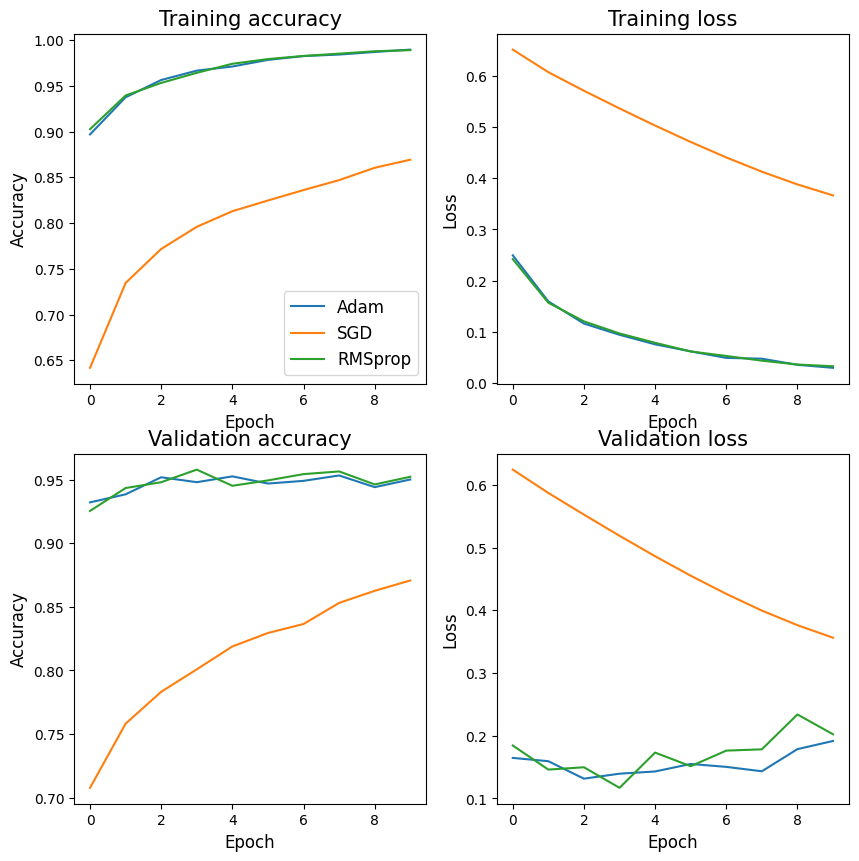

In [34]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(opt_histories[0].history['accuracy'])
plt.plot(opt_histories[1].history['accuracy'])
plt.plot(opt_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Adam', 'SGD', 'RMSprop'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(opt_histories[0].history['loss'])
plt.plot(opt_histories[1].history['loss'])
plt.plot(opt_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(opt_histories[0].history['val_accuracy'])
plt.plot(opt_histories[1].history['val_accuracy'])
plt.plot(opt_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(opt_histories[0].history['val_loss'])
plt.plot(opt_histories[1].history['val_loss'])
plt.plot(opt_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)


### Learning rate

In [35]:
# Define list of optimizers to compare
learning_rates = [0.01, 0.001, 0.0001]
lr_histories = []

# Train and evaluate the model with each optimizer
for learning_rate in learning_rates:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit([X_text_train, X_num_train], Y_train,
                              batch_size=32,
                              epochs=10,
                              verbose=1,
                              validation_data=([X_text_val, X_num_val], Y_val))
     lr_histories.append(history)

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8889 - loss: 0.2765 - val_accuracy: 0.9043 - val_loss: 0.2416
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9063 - loss: 0.2317 - val_accuracy: 0.9093 - val_loss: 0.2209
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9094 - loss: 0.2200 - val_accuracy: 0.9145 - val_loss: 0.2201
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9164 - loss: 0.2008 - val_accuracy: 0.9206 - val_loss: 0.2114
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9234 - loss: 0.1894 - val_accuracy: 0.9230 - val_loss: 0.1936
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9261 - loss: 0.1787 - val_accuracy: 0.9237 - val_loss: 0.1948
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9308 - loss: 0.1686 - val_accuracy: 0.9174 - val_loss: 0.2063
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9330 - loss: 0.1706 - val_accurac

Text(0.5, 0, 'Epoch')

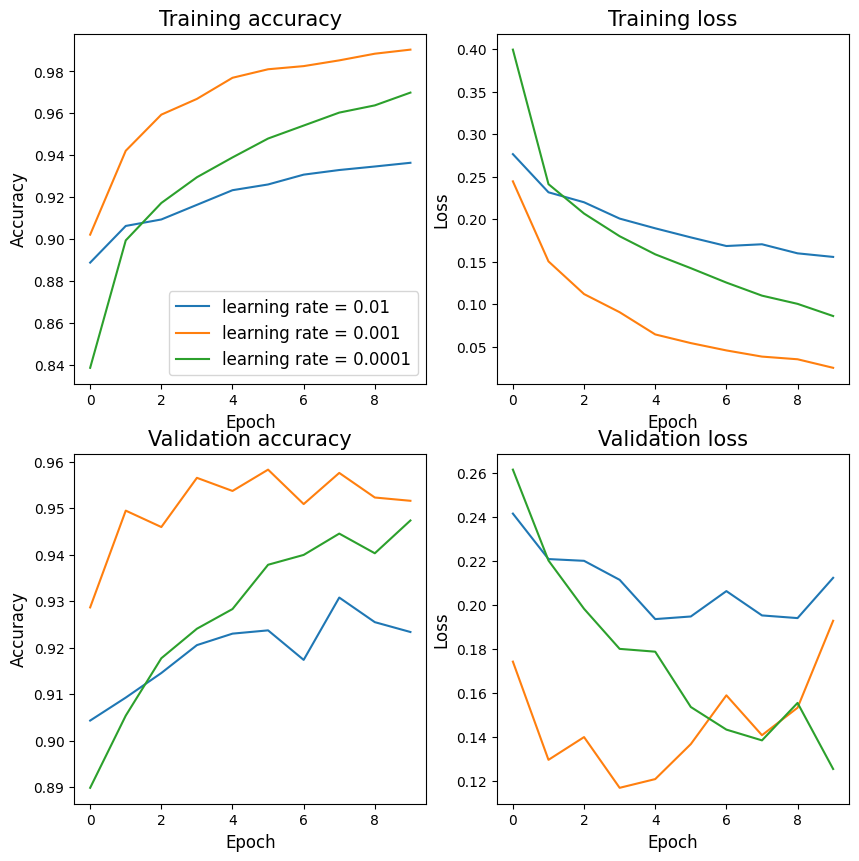

In [36]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(lr_histories[0].history['accuracy'])
plt.plot(lr_histories[1].history['accuracy'])
plt.plot(lr_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['learning rate = 0.01', 'learning rate = 0.001', 'learning rate = 0.0001'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(lr_histories[0].history['loss'])
plt.plot(lr_histories[1].history['loss'])
plt.plot(lr_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(lr_histories[0].history['val_accuracy'])
plt.plot(lr_histories[1].history['val_accuracy'])
plt.plot(lr_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(lr_histories[0].history['val_loss'])
plt.plot(lr_histories[1].history['val_loss'])
plt.plot(lr_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

### Batch size

In [37]:
# Define list of optimizers to compare
batch_sizes = [16, 32, 64]
bs_histories = []

# Train and evaluate the model with each optimizer
for batch_size in batch_sizes:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit([X_text_train, X_num_train], Y_train,
                              batch_size=batch_size,
                              epochs=10,
                              verbose=1,
                              validation_data=([X_text_val, X_num_val], Y_val))
     bs_histories.append(history)

Epoch 1/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9012 - loss: 0.2379 - val_accuracy: 0.9326 - val_loss: 0.1793
Epoch 2/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9397 - loss: 0.1518 - val_accuracy: 0.9442 - val_loss: 0.1401
Epoch 3/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9590 - loss: 0.1146 - val_accuracy: 0.9484 - val_loss: 0.1408
Epoch 4/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9659 - loss: 0.0940 - val_accuracy: 0.9548 - val_loss: 0.1242
Epoch 5/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9701 - loss: 0.0787 - val_accuracy: 0.9492 - val_loss: 0.1407
Epoch 6/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9762 - loss: 0.0658 - val_accuracy: 0.9502 - val_loss: 0.1512
Epoch 7/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9785 - loss: 0.0595 - val_accuracy: 0.9576 - val_loss: 0.1275
Epoch 8/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9827 - loss: 0.0460 - val_accuracy: 0.

Text(0.5, 0, 'Epoch')

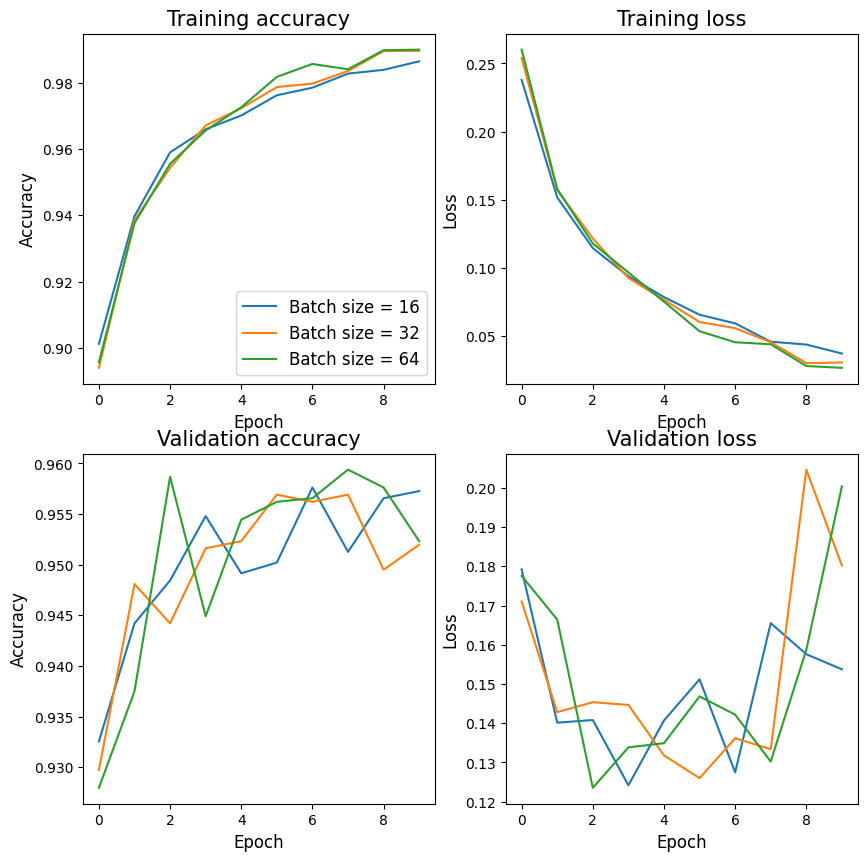

In [38]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(bs_histories[0].history['accuracy'])
plt.plot(bs_histories[1].history['accuracy'])
plt.plot(bs_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Batch size = 16', 'Batch size = 32', 'Batch size = 64'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(bs_histories[0].history['loss'])
plt.plot(bs_histories[1].history['loss'])
plt.plot(bs_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(bs_histories[0].history['val_accuracy'])
plt.plot(bs_histories[1].history['val_accuracy'])
plt.plot(bs_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(bs_histories[0].history['val_loss'])
plt.plot(bs_histories[1].history['val_loss'])
plt.plot(bs_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

### Retrain the model with best hyperparameters

In [39]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [40]:
best_model = phising_CNNModel(vocab_size=vocab_size, embedding_size=256, conv_num=2, 
                              conv_filters=64, conv_kernel_size=3, 
                              conv_activation='relu', fc_num=3, 
                              fc_units=128, fc_activation='relu', 
                              fc_dropout=0.0, learning_rate=0.001, optimizer='Adam')

In [41]:
history = best_model.fit([text_train, num_train_std], y_train, epochs=30, 
                         batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9042 - loss: 0.2373 - val_accuracy: 0.9393 - val_loss: 0.1610
Epoch 2/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9457 - loss: 0.1448 - val_accuracy: 0.9477 - val_loss: 0.1314
Epoch 3/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9579 - loss: 0.1098 - val_accuracy: 0.9562 - val_loss: 0.1189
Epoch 4/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9691 - loss: 0.0872 - val_accuracy: 0.9562 - val_loss: 0.1092
Epoch 5/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9754 - loss: 0.0703 - val_accuracy: 0.9626 - val_loss: 0.1135
Epoch 6/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9786 - loss: 0.0601 - val_accuracy: 0.9520 - val_loss: 0.1267
Epoch 7/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9820 - loss: 0.0515 - val_accuracy: 0.9590 - val_loss: 0.1187


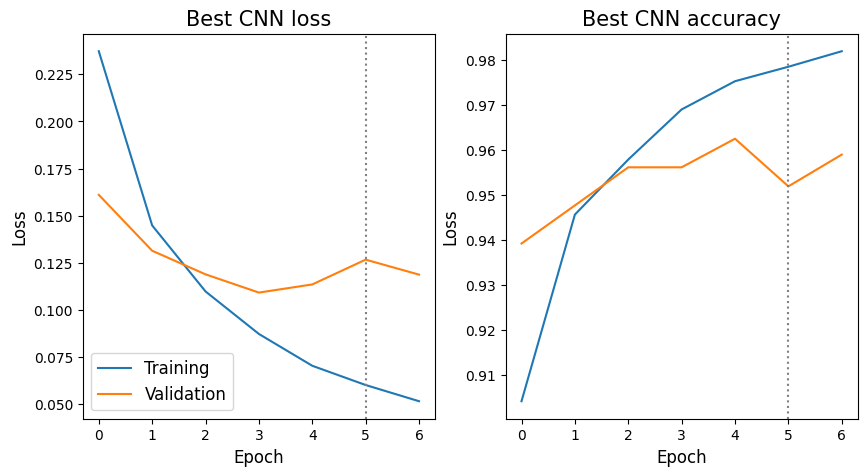

In [43]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Best CNN loss", fontsize=15)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.axvline(x=5, color='grey',linestyle=":")
plt.legend(["Training", "Validation"], loc="best", fontsize=12)

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Best CNN accuracy", fontsize=15)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.axvline(x=5, color='grey',linestyle=":")

In [44]:
keras.utils.plot_model(best_model, r"C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main/bestCNN_arch.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Save the trained CNN

In [46]:
best_model.save(r"C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\models\deep_learining\CNN.keras")

In [47]:
CNN = tf.keras.models.load_model(r"C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\models\deep_learining\CNN.keras")